# Notebook: Pipeline - Disaster Tweets

Este notebook contém uma versão interativa do pipeline.

O notebook pressupõe que os seguintes arquivos/folders existem na mesma pasta do projeto:
- `train.csv` (opcional para re-treino/EDA)
- `outputs/` (gerado pelo `pipeline_disaster_tweets.py`) contendo: `model_summary.csv`, `tfidf_vectorizer.joblib`, `model_*.joblib`, e imagens de matriz de confusão.

----


In [7]:
import os
from pathlib import Path
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown

PROJECT_DIR = Path().resolve()  # adjust if needed
OUTPUTS = PROJECT_DIR / 'outputs'
TRAIN_CSV = PROJECT_DIR / 'train.csv'

print('Project dir:', PROJECT_DIR)
print('Outputs dir exists?:', OUTPUTS.exists())

Project dir: D:\Rafael Hessel\Documents\Ciencia de dados\Semestre 3\Projeto Aplicado 2\Workspace Proj Apl 2
Outputs dir exists?: True


## 2) Mostrar resumo dos modelos (model_summary.csv)

In [8]:
# Load model summary
summary_path = OUTPUTS / 'model_summary.csv'
if summary_path.exists():
    df_summary = pd.read_csv(summary_path)
    display(df_summary)
else:
    print('model_summary.csv não encontrado em', summary_path)

,model,acc,prec,rec,f1
0,svc,0.803677,0.801358,0.721713,0.759453
1,logreg,0.808930,0.856582,0.666667,0.749785
2,nb,0.807617,0.857426,0.662080,0.747196


## 3) Matrizes de confusão salvas

**cm_logreg.png**

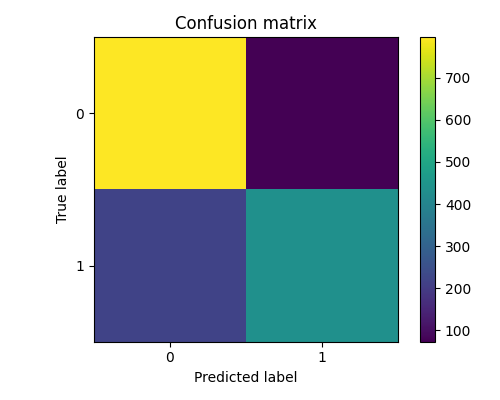

**cm_nb.png**

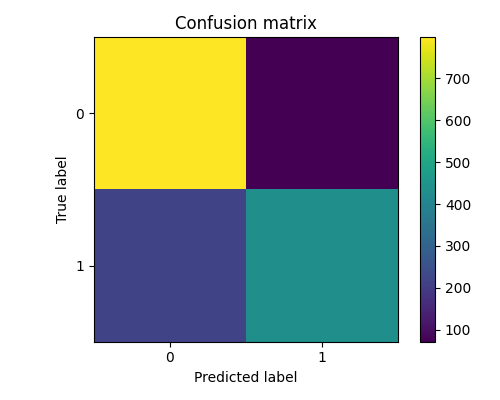

**cm_svc.png**

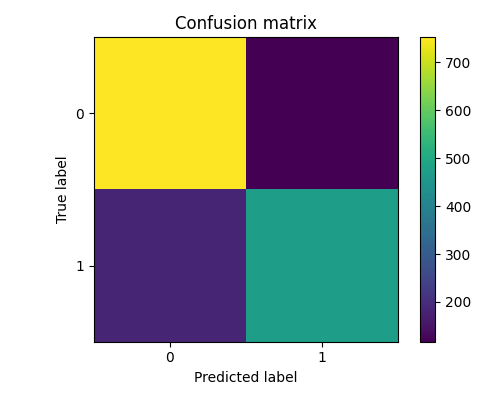

**cm_logreg.png**

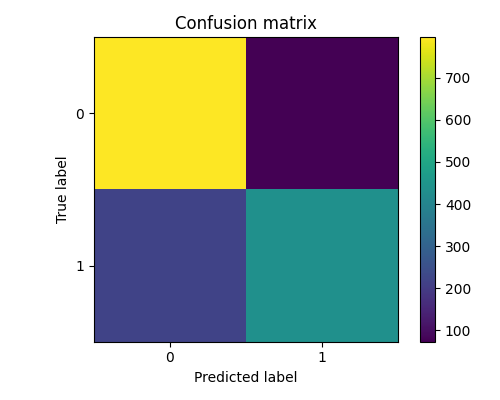

**cm_nb.png**

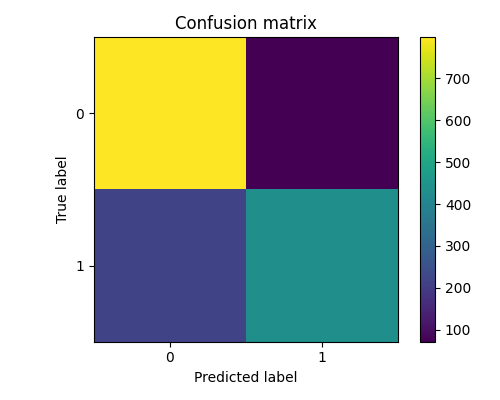

**cm_svc.png**

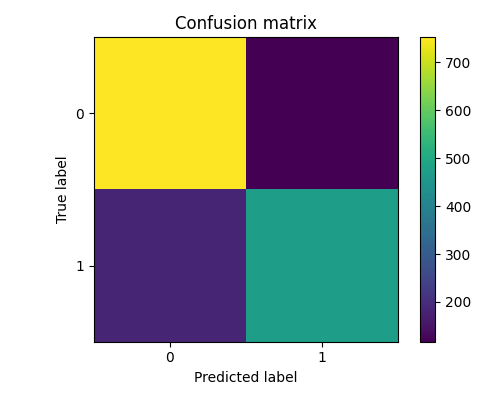

**cm_logreg.png**

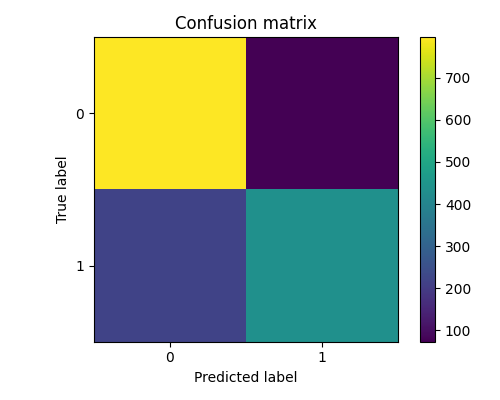

**cm_nb.png**

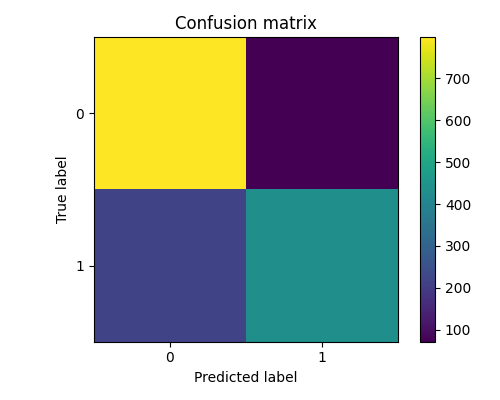

**cm_svc.png**

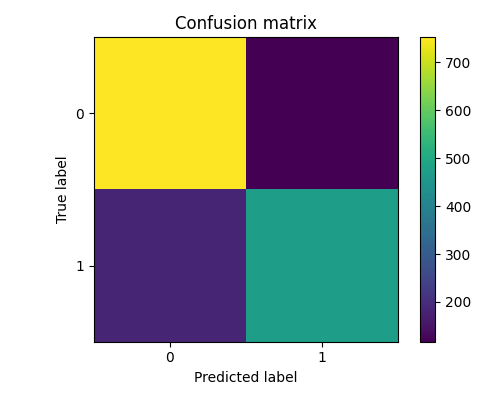

In [9]:
# Display confusion matrix images
cm_files = list(OUTPUTS.glob('cm_*.png')) + list(OUTPUTS.glob('confusion_*.png')) + list(OUTPUTS.glob('*cm*.png')) + list(OUTPUTS.glob('cm_*.png'))
if not cm_files:
    cm_files = list(OUTPUTS.glob('*confusion*.png')) + list(OUTPUTS.glob('*cm*.png'))
if cm_files:
    for p in cm_files:
        display(Markdown(f'**{p.name}**'))
        display(Image(str(p)))
else:
    print('Nenhuma imagem de matriz de confusão encontrada em', OUTPUTS)

## 4) Carregar vetorizador e modelos salvos

In [10]:
vect_path = OUTPUTS / 'tfidf_vectorizer.joblib'
models = {}
if vect_path.exists():
    vect = joblib.load(vect_path)
    print('Loaded vectorizer from', vect_path)
else:
    vect = None
    print('Vectorizer not found at', vect_path)

for p in OUTPUTS.glob('model_*.joblib'):
    try:
        models[p.stem] = joblib.load(p)
        print('Loaded', p.name)
    except Exception as e:
        print('Failed to load', p, e)

for p in OUTPUTS.glob('*.joblib'):
    if p.stem not in models:
        try:
            models[p.stem] = joblib.load(p)
            print('Loaded', p.name)
        except Exception:
            pass

print('\nModels available:', list(models.keys()))

Loaded vectorizer from D:\Rafael Hessel\Documents\Ciencia de dados\Semestre 3\Projeto Aplicado 2\Workspace Proj Apl 2\outputs\tfidf_vectorizer.joblib
Loaded model_logreg.joblib
Loaded model_nb.joblib
Loaded model_svc.joblib
Loaded tfidf_vectorizer.joblib

Models available: ['model_logreg', 'model_nb', 'model_svc', 'tfidf_vectorizer']


## 5) Testar previsões com exemplos manuais

In [11]:
examples = [
    'There is a wildfire near the river, people need help and evacuation',
    'I love hiking in the mountains, the view is amazing',
    'Flooding in my street after the storm, houses damaged',
    'The party last night was lit!'
]

if vect is None or not models:
    print('Vetorizador ou modelos não disponíveis. Execute o pipeline primeiro para gerar artifacts em outputs/.')
else:
    chosen = None
    for k in ['svc', 'logreg', 'nb', 'model_logreg', 'logreg_model', 'model_svc']:
        if any(k in name for name in models):
            # pick the first matching key
            key = next(name for name in models if k in name)
            chosen = models[key]
            print('Using model:', key)
            break
    if chosen is None:
        key, chosen = next(iter(models.items()))
        print('Using model:', key)

    X = vect.transform(examples)
    preds = chosen.predict(X)
    print('Predictions (1 = disaster, 0 = not):')
    for t, p in zip(examples, preds):
        print(f' - ({p})', t)

Using model: model_svc
Predictions (1 = disaster, 0 = not):
 - (1) There is a wildfire near the river, people need help and evacuation
 - (0) I love hiking in the mountains, the view is amazing
 - (1) Flooding in my street after the storm, houses damaged
 - (0) The party last night was lit!


## 6) EDA rápido: palavras mais frequentes (usando TF-IDF features)

In [12]:
if vect is None:
    print('Vectorizer not available.')
else:
    try:
        import numpy as np
        feature_names = vect.get_feature_names_out()
        if TRAIN_CSV.exists():
            df = pd.read_csv(TRAIN_CSV)
            texts = df['text'].fillna('').astype(str)
            X = vect.transform(texts)
            mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
            top_idx = mean_tfidf.argsort()[::-1][:40]
            top_feats = [(feature_names[i], mean_tfidf[i]) for i in top_idx]
            top_df = pd.DataFrame(top_feats, columns=['feature','mean_tfidf'])
            display(top_df.head(40))
        else:
            print('train.csv não encontrado, não foi possível calcular frequências.')
    except Exception as e:
        print('Erro ao extrair features TF-IDF:', e)

,feature,mean_tfidf
0,co,0.197132
1,to,0.071163
2,you,0.041785
3,have,0.016283
4,will,0.011755
5,not,0.011484
6,like,0.009813
7,one,0.009443
8,get,0.007574
9,fire,0.007432
